In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import pickle

import matplotlib.patches as mpatches
from sklearn.decomposition import PCA

from apollon.som import utilities
from apollon.som.som import SelfOrganizingMap

# Comparison of TimbreTrack-SOMs with full and reduced feature sets.

The reduced the example ommits the following features
* Spread
* Kurtosis
* Skewness

## 1. Preprocessing

In [3]:
# full data set
data = pd.read_csv('tt_features_only_good.csv', index_col=0)

# collection array indices
coam = data.index[data['collection'] == 'coam']
heinitz = data.index[data['collection'] == 'heinitz']
bader = data.index[data['collection'] == 'bader']

In [4]:
meta = pd.read_csv('../meta/esra-export.csv', index_col=0)

In [5]:
# uyghur array index
cnd = meta['ethnic_group'] == "Uyghur"
meta.index[cnd]

uidx = []
for i in meta.index[cnd]:
    foo = data.index[data.id == i]
    if foo.size != 0:
        uidx.append(foo[0])
uyghur = pd.Index(uidx)

In [6]:
features = [
    'centroid_mean', 'centroid_std',
    'spread_mean', 'spread_std', 
    'skewness_mean', 'skewness_std',
    'kurtosis_mean', 'kurtosis_std',
    'flux_mean', 'flux_std',
    'roughness_mean', 'roughness_std',
    'sharpness_mean', 'sharpness_std',
    'loudness_mean', 'loudness_std']

features_reduced = [
    'centroid_mean', 'centroid_std',
    'flux_mean', 'flux_std',
    'roughness_mean', 'roughness_std',
    'sharpness_mean', 'sharpness_std',
    'loudness_mean', 'loudness_std']

In [7]:
features_num_full = {i:feat for i, feat in enumerate(features)}
features_num_reduced = {i:feat for i, feat in enumerate(features_reduced)}
features_colors = {feat:cm.tab20(i) for i, feat in enumerate(features)}

In [8]:
# global constants
SEED = 432
N_ITER = 10000
UMATRIX = {'origin':'lower', 'cmap':'terrain', 'alpha':.8,
           'interpolation':'bicubic', 'zorder':0}
MAX_FEATURE = {'origin':'lower', 'alpha':.8, 'zorder':0}

## 2. Full SOM

### 2.1 Features

In [9]:
sfm = data[features].values

# standartized feature matrices
feature_mean = sfm.mean(axis=0)
feature_std = sfm.std(axis=0)
sfm = (sfm - feature_mean) / feature_std

# collection features
coam_feat = sfm[coam]
heinitz_feat = sfm[heinitz]
bader_feat = sfm[bader]
uyghur_feat = sfm[uyghur]

### 2.2 SOM

In [10]:
# init FULL som
s = SelfOrganizingMap((40, 40, sfm.shape[-1]), nh=30, init_distr='uniform', 
                       n_iter=N_ITER, seed=SEED)

pca = PCA(2)
pca.fit(sfm)

for i in range(s.dx):
    for j in range(s.dy):
        s.weights[i*s.dx+j] = pca.components_[0] * i + pca.components_[1] * j
        
# estimated computation time in minutes
one_epoche = 137 / 1000
one_epoche * s.n_iter / 60

22.833333333333332

In [11]:
%time s.fit(sfm)

with open('../esra_tt_1000.weights', 'wb') as fobj:
    pickle.dump(s.weights, fobj)

CPU times: user 23min 16s, sys: 12 s, total: 23min 28s
Wall time: 23min 29s


### 2.3 Results

In [12]:
# U-matrix
um = utilities.umatrix(s.weights, s.shape)

# coam positions
flat_idx = utilities.get_winner(s.weights, coam_feat)
coam_x, coam_y = unravel_index(flat_idx, s.shape)

# heinitz positions
flat_idx = utilities.get_winner(s.weights, heinitz_feat)
heinitz_x, heinitz_y = unravel_index(flat_idx, s.shape)

# bader positions
flat_idx = utilities.get_winner(s.weights, bader_feat)
bader_x, bader_y = unravel_index(flat_idx, s.shape)

# uyghur positions
flat_idx = utilities.get_winner(s.weights, uyghur_feat)
uyghur_x, uyghur_y = unravel_index(flat_idx, s.shape)

## 3. Reduced SOM

### 3.1 Features

In [13]:
sfm_reduced = data[features_reduced].values

# standartized feature matrices
feature_mean_reduced = sfm_reduced.mean(axis=0)
feature_std_reduced = sfm_reduced.std(axis=0)
sfm_reduced = (sfm_reduced - feature_mean_reduced) / feature_std_reduced


# collection features
coam_feat_reduced = sfm_reduced[coam]
heinitz_feat_reduced = sfm_reduced[heinitz]
bader_feat_reduced = sfm_reduced[bader]
uyghur_feat_reduced = sfm_reduced[uyghur]

### 3.2 SOM

In [14]:
# init REDUCED som

s_reduced = SelfOrganizingMap((40, 40, sfm_reduced.shape[-1]), nh=30, init_distr='uniform',
                       n_iter=N_ITER, seed=SEED)

pca = PCA(2)
pca.fit(sfm_reduced)

for i in range(s.dx):
    for j in range(s.dy):
        s_reduced.weights[i*s.dx+j] = pca.components_[0] * i + pca.components_[1] * j

In [15]:
%time s_reduced.fit(sfm_reduced)

with open('../esra_tt_reduced.weights', 'wb') as fobj:
    pickle.dump(s_reduced.weights, fobj)

CPU times: user 20min 39s, sys: 12.1 s, total: 20min 51s
Wall time: 20min 53s


### 3.3 Results

In [16]:
# U-matrix
um_reduced = utilities.umatrix(s_reduced.weights, s_reduced.shape)

# coam positions
flat_idx_r = utilities.get_winner(s_reduced.weights, coam_feat_reduced)
coam_r_x, coam_r_y = unravel_index(flat_idx_r, s_reduced.shape)

# heinitz positions
flat_idx_r = utilities.get_winner(s_reduced.weights, heinitz_feat_reduced)
heinitz_r_x, heinitz_r_y = unravel_index(flat_idx_r, s_reduced.shape)

# bader positions
flat_idx_r = utilities.get_winner(s_reduced.weights, bader_feat_reduced)
bader_r_x, bader_r_y = unravel_index(flat_idx_r, s_reduced.shape)

# uyghur positions
flat_idx = utilities.get_winner(s_reduced.weights, uyghur_feat_reduced)
uyghur_r_x, uyghur_r_y = unravel_index(flat_idx, s_reduced.shape)

## 4. Comparison

In [17]:
pos_heinitz_full = {'x': heinitz_y, 'y': heinitz_x}
pos_coam_full = {'x': coam_y, 'y': coam_x}
pos_bader_full = {'x': bader_y, 'y': bader_x}
pos_uyghur_full = {'x': uyghur_y, 'y': uyghur_x}

pos_full = {'heinitz': pos_heinitz_full,
            'coam': pos_coam_full,
            'bader': pos_bader_full,
            'uyghu': pos_uyghur_full}

pos_heinitz_reduced = {'x': heinitz_r_y, 'y': heinitz_r_x}
pos_coam_reduced = {'x': coam_r_y, 'y': coam_r_x}
pos_bader_reduced = {'x': bader_r_y, 'y': bader_r_x}
pos_uyghur_reduced = {'x': uyghur_r_y, 'y': uyghur_r_x}

pos_reduced = {'heinitz': pos_heinitz_reduced,
            'coam': pos_coam_reduced,
            'bader': pos_bader_reduced,
            'uyghu': pos_uyghur_reduced}

args_heinitz = {'label':'Heinitz','c':'C1', 'marker':'^',
                's':80, 'alpha':.8, 'zorder':1}

args_coam = {'label':'COAM','c':'red', 'marker':'+',
             's':80, 'alpha':.8, 'zorder':1}

args_bader = {'label':'Bader', 'c':'k', 'marker':'o',
              's':80, 'alpha':.8, 'zorder':1}

args_uyghur = {'label':'Uyghur', 'c':'Yellow', 'marker':'o',
               's':80, 'alpha':1, 'zorder':2, 'edgecolor':'k'}

sargs = {'heinitz': args_heinitz, 
         'coam': args_coam,
         'bader': args_bader,
         'uyghur': args_uyghur}

### 4.1 Collections on U-Matrix

Standard U-Matrix visualization with collection-based clustering. Piece with `ethnic_group == 'Uyghur'` are emphazised in yellow.

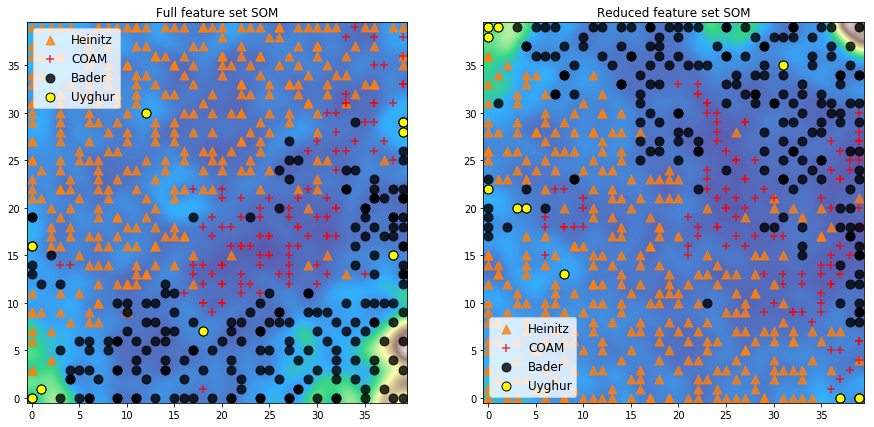

In [18]:
fig, (ax_full, ax_reduced) = subplots(1, 2, figsize=(15, 12))

ax_full.imshow(um, **UMATRIX)
patches = [ax_full.scatter(**pos, **args) 
           for (pos, args) in zip(pos_full.values(), sargs.values())]
ax_full.legend(loc=2, fontsize=12)
ax_full.set_title('Full feature set SOM');

ax_reduced.imshow(um_reduced, **UMATRIX)
patches = [ax_reduced.scatter(**pos, **args) 
           for (pos, args) in zip(pos_reduced.values(), sargs.values())]
ax_reduced.legend(loc=3, fontsize=12)
ax_reduced.set_title('Reduced feature set SOM');

### 3.4 Dominant Feature

Map background corresponds to the stronges feature per unit.

In [30]:
tpos_full = {
    0: (5, 15),
    1: (34, 16),
    2: (2, 5),
    3: (5, 22),
    4: (3, 0),
    5: (17, 9.5),
    6: (4, 4),
    7: (38.5, 32), 
    8: (35, 23),
    9: (35, 20),
   10: (12, 27)
}

tpos_reduced = {
    0: (3, 23),
    1: (34, 32),
    2: (6, 36),
    3: (1, 25),
    4: (5, 38),
    5: (5, 22),
    6: (1, 35),
    7: (37, 4), 
    8: (38, 4),
    9: (35, 3),
   10: (9, 15)
}

ap = dict(facecolor='black', shrink=0.05, width=1, headwidth=1)

text_pos_full = [{'s':i,  'xy':(x, y), 'xytext':tpos, 'arrowprops':ap, 'size':12}
    for i, (x, y, tpos) in enumerate(
        zip(pos_uyghur_full['x'], 
            pos_uyghur_full['y'],
            tpos_full.values()))]

text_pos_reduced = [{'s':i,  'xy':(x, y), 'xytext':tpos, 'arrowprops':ap, 'size':12} 
    for i, (x, y, tpos) in enumerate(
        zip(pos_uyghur_reduced['x'], 
            pos_uyghur_reduced['y'],
            tpos_reduced.values()))]

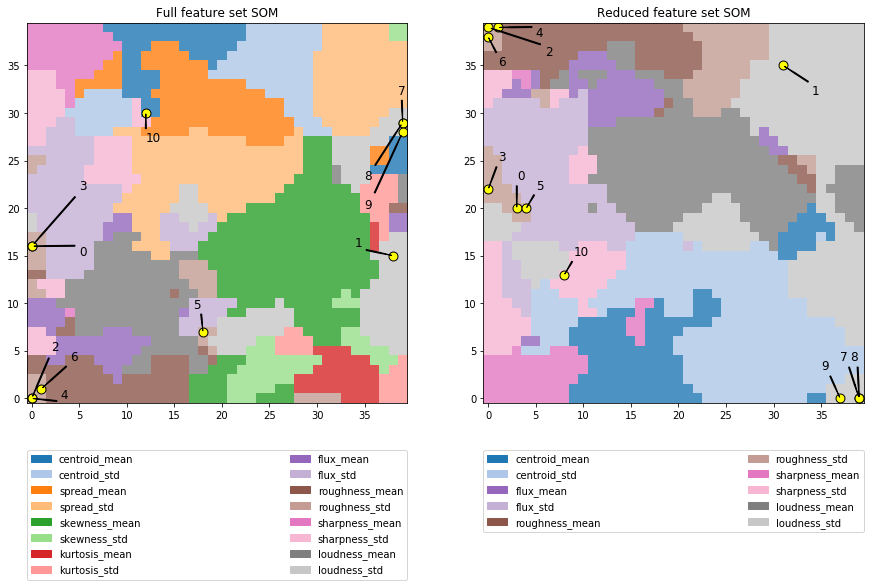

In [31]:
legend_args = {'bbox_to_anchor':(0., -.02, 1., -.102), 'loc':1,
               'ncol':2, 'mode':'expand', 'borderaxespad':0.}

fig, (ax_full, ax_reduced) = subplots(1, 2, figsize=(15, 12))


max_feat_full = array([features_colors[features_num_full[i]] 
                       for i in s.weights.argmax(axis=1)])
max_feat_reduced = array([features_colors[features_num_reduced[i]]
                          for i in s_reduced.weights.argmax(axis=1)])

proxies_full = [mpatches.Patch(color=features_colors[feat], label=feat)
                for feat in features]

proxies_reduced = [mpatches.Patch(color=features_colors[feat], label=feat)
                   for feat in features_reduced]

ax_full.imshow(max_feat_full.reshape(*s.shape, -1), **MAX_FEATURE)
ax_full.scatter(**pos_uyghur_full, **args_uyghur)
for targs in text_pos_full:
    ax_full.annotate(**targs)

ax_full.legend(handles=proxies_full, **legend_args)
ax_full.set_title('Full feature set SOM');

ax_reduced.imshow(max_feat_reduced.reshape(*s_reduced.shape, -1), **MAX_FEATURE)
ax_reduced.scatter(**pos_uyghur_reduced, **args_uyghur)
for targs in text_pos_reduced:
    ax_reduced.annotate(**targs)


ax_reduced.legend(handles=proxies_reduced, **legend_args)
ax_reduced.set_title('Reduced feature set SOM');

0: [muqädimä for Rak muqam](https://esra.fbkultur.uni-hamburg.de/explore/view?entity_id=675)

1: [muqädimä for Cabbiyat muqam](https://esra.fbkultur.uni-hamburg.de/explore/view?entity_id=676)

2: [muqädimä for Sega muqam](https://esra.fbkultur.uni-hamburg.de/explore/view?entity_id=677)


3: [muqädimä for Cahargah muqam](https://esra.fbkultur.uni-hamburg.de/explore/view?entity_id=678)


4: [muqädimä for Panjigah muqam](https://esra.fbkultur.uni-hamburg.de/explore/view?entity_id=679)


5: [muqädimä for Özhal muqam](https://esra.fbkultur.uni-hamburg.de/explore/view?entity_id=680)


6: [muqädimä for Ajam muqam](https://esra.fbkultur.uni-hamburg.de/explore/view?entity_id=681)


7: [muqädimä for Ussaq muqam](https://esra.fbkultur.uni-hamburg.de/explore/view?entity_id=682)


8: [muqädimä for Bayat muqam](https://esra.fbkultur.uni-hamburg.de/explore/view?entity_id=683)


9: [muqäddimä for Nava muqam](https://esra.fbkultur.uni-hamburg.de/explore/view?entity_id=684)


10: [muqäddimä for Musavräk muqam](https://esra.fbkultur.uni-hamburg.de/explore/view?entity_id=685)
